### 2D Example - Main Script

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import sys
import os
import pickle
import flopy
import geopandas as gpd
from shapely.geometry import LineString,Point,Polygon,MultiPolygon,MultiPoint,shape

%load_ext autoreload
%autoreload 2

import loopflopy
import loopflopy.utils as utils

print(loopflopy.__file__)
modules = utils.list_modules(loopflopy)
for module in modules: 
    print(module)

c:\users\00105295\projects\loopflopy\loopflopy\__init__.py
dem
disv2disu
flowmodel
flowmodel_routines
geomodel
geomodel_routines
mesh
mesh_routines
modelling_routines_old
observations
project
spatial
spatial_routines
structuralmodel
surfacerefinement
utils


### 1. Setup Project

In [2]:
# Project setup
name = 'example'
workspace = '../modelfiles/'
results = '../results/'
figures = '../figures/'
triexe = '../exe/triangle.exe'
mfexe_name = '../exe/mf6.exe'

from loopflopy.project import Project
project = Project(name, workspace, results, figures, triexe, mfexe_name)

### 2. Spatial

CHD East  [(385000, 6530000), (385000, 6530001)]
                                      geometry
0  LINESTRING (385000 6530000, 385000 6530001)
CHD West  [(360000, 6535000), (360000, 6535001)]


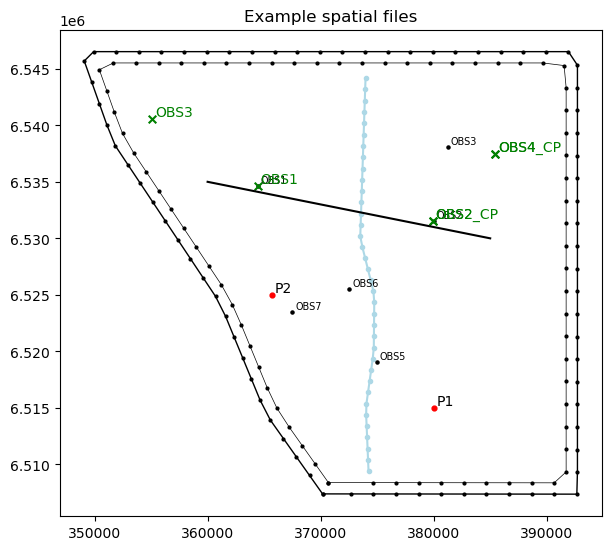

In [3]:
from loopflopy.spatial import Spatial
spatial = Spatial(epsg = 28350)

model_extent = [(360000, 6535000),(385000, 6530000)]
spatial.model_extent = model_extent

import process_spatial
process_spatial.model_boundary(spatial, boundary_buff = 1000, simplify_tolerance = 800, node_spacing = 2000)
process_spatial.obs_bores(spatial)
process_spatial.geo_bores(spatial)
process_spatial.pump_bores(spatial)
process_spatial.head_boundary(spatial)
process_spatial.faults(spatial)

spatial.x0, spatial.x1 = model_extent[0][0], model_extent[1][0]
spatial.y0, spatial.y1 = model_extent[0][1], model_extent[1][1]

process_spatial.plot_spatial(spatial, model_extent)

### 3. Structural Model

In [4]:
# Create Structural Model
geodata_fname = '../data/example_data.xlsx'
data_sheetname = 'geo_bores'
strat_sheetname = 'strat'
bbox = [(348000, 6500000, -2000), (400000, 6550000, 500)] #[(x0, y0, z0), (x1, y1, z1)]
from loopflopy.structuralmodel import StructuralModel
structuralmodel = StructuralModel(spatial, bbox, geodata_fname, data_sheetname, strat_sheetname)

import process_structural
process_structural.prepare_strat_column(structuralmodel)
process_structural.prepare_geodata(structuralmodel, spatial)
process_structural.create_structuralmodel(structuralmodel)

structuralmodel.faults = ['Fault']

                          projected onto fault surface estimating from fault normal


1.6.1
Fault included!


c:\Users\00105295\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


(360000, 6535000)


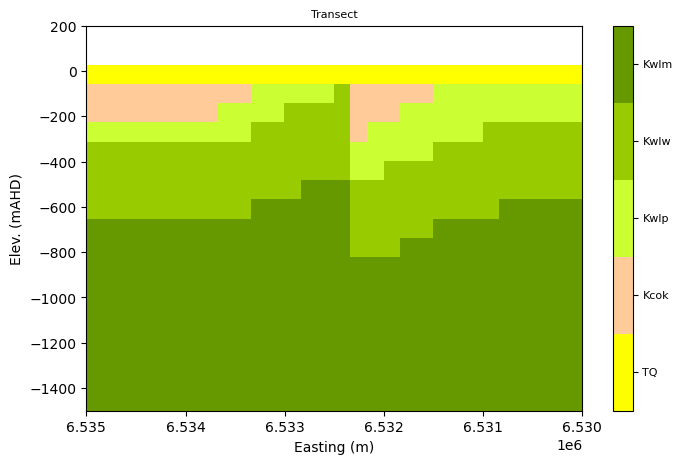

In [5]:
# Plotting of structural model (this is not for the flow model)
start = model_extent[0] 
end = model_extent[1]
z0 = -1500 # just for plotting. Make sure within bbox of structural model
z1 = 200   # just for plotting. Make sure within bbox of structural model
nh, nz = 30, 20 # plotting resolution
print(start)
structuralmodel.plot_xytransect(start = start, end = end, z0 = z0, z1 = z1, nh = nh, nz = nz)

### 4. Meshing

In [119]:
special_cells = {
                 'chd': ['east', 'west'], 
                 #'wel': ['pumpbores'], 
                 #'obs': ['obsbores'], 
                 }

# Create mesh object
from loopflopy.mesh import Mesh
mesh = Mesh(plangrid = 'transect', special_cells = special_cells) # special cells to identify as arguements 

### FOR FLOW MODEL!!! ####
mesh.ncol = 30
mesh.nrow = 1
mesh.ncpl = mesh.nrow * mesh.ncol


In [120]:
print(spatial.x0, spatial.y0)
print(spatial.x1, spatial.y1)
mesh.create_mesh(project, spatial)
print('number of cells in plan = ', mesh.ncpl)
mesh.locate_special_cells(spatial)
mesh.chd_west_cells

360000 6535000
385000 6530000
angrot  -11.309932474020215
number of cells in plan =  30
Group =  chd ['east', 'west']
chd_east_cells [29]
chd_west_cells [0]


array([0], dtype=object)

(np.float64(358740.1941932431),
 np.float64(386455.9219418951),
 np.float64(6529700.970966215),
 np.float64(6536279.609709476))

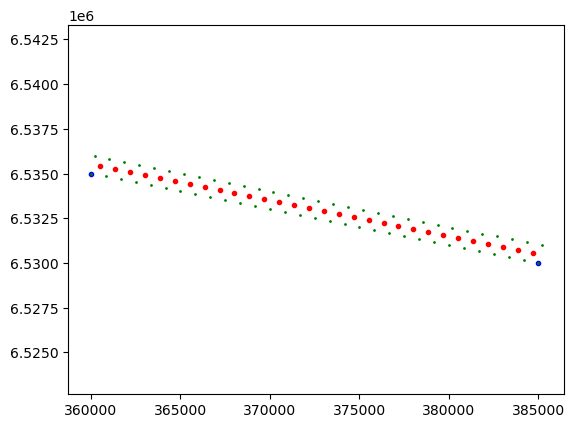

In [8]:
# Plot of cell centres (red), vertices (green) and transect (blue)
plt.plot(mesh.xcenters, mesh.ycenters, 'ro', ms= 3.)
plt.plot(spatial.x0, spatial.y0, 'bo', ms = 3.)
plt.plot(spatial.x1, spatial.y1, 'bo', ms = 3.)
for ivert in mesh.vertices:
    i, x, y = ivert
    plt.plot(x, y, 'go', ms = 1.)
    #plt.text(x, y, str(i))
plt.axis('equal')

### 5. Geomodel

In [101]:
# Set up Geomodel (lithological block model of cells)
scenario = 'example'
vertgrid = 'con'    # {voxel: nlay, z0, z1} {con:   nls, res} {con2:  nls, res, max_thick}

from loopflopy.geomodel import Geomodel
geomodel = Geomodel(scenario, vertgrid, z0, z1, transect = True, nls = 3, res = 100)

geomodel.create_lith_dis_arrays(mesh, structuralmodel)
geomodel.vgrid = flopy.discretization.VertexGrid(vertices=mesh.vertices, cell2d=mesh.cell2d, 
                                                 ncpl = mesh.ncpl, top = geomodel.top_geo, botm = geomodel.botm)

   Creating Geomodel (lithology and discretisation arrays) for  example  ...
nlay =  17
ncpl =  30
nlg number of geo layers =  5
vf shape  (450,)
Time taken =  0.481004


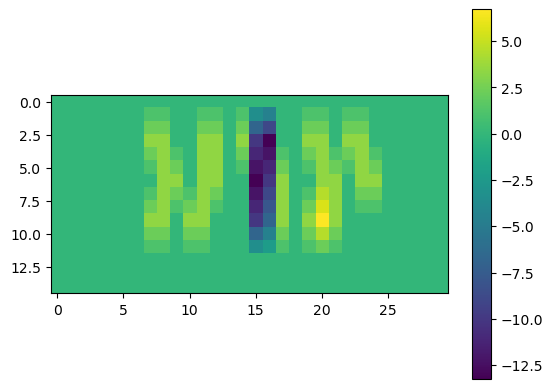

In [102]:
geomodel.ang2.shape
plt.imshow(geomodel.ang2)
plt.colorbar()

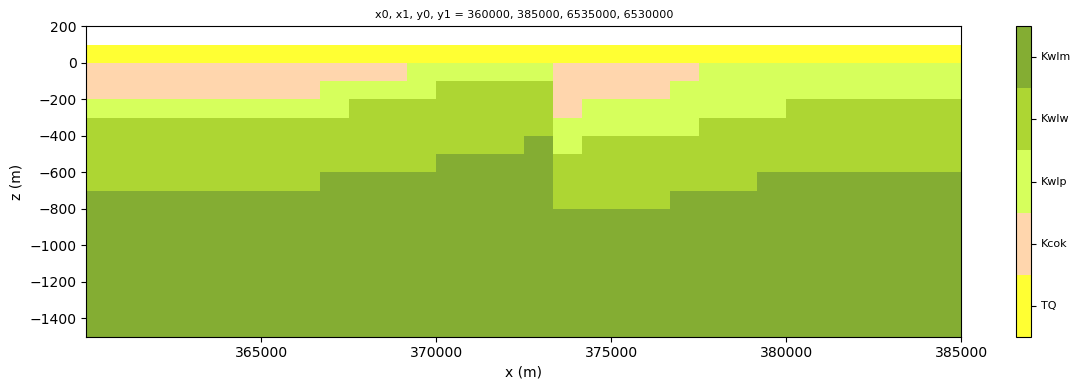

In [103]:
geomodel.geomodel_transect_lith(structuralmodel, spatial)

In [198]:
# FILL CELL PROPERTIES
props = pd.read_excel(structuralmodel.geodata_fname, sheet_name = 'properties')
props = props.drop(index=[0]).reset_index()#inplace=True) # drop first row as it is ground
geomodel.hk_perlay = props.hk.tolist()
geomodel.vk_perlay = props.vk.tolist()
geomodel.ss_perlay = props.ss.tolist()
geomodel.sy_perlay = props.sy.tolist()
geomodel.iconvert_perlay = props.iconvert.tolist()
geomodel.fill_cell_properties(mesh)
props

   Filling cell properties for  example  ...
ang1 shape  (15, 30)
408
angle1 shape  (408,)
Time taken =  0.0


,index,unit,hk,vk,ss,sy,iconvert
0,1,TQ,50.0,5.0,0.0001,0.1,1.0
1,2,Kcok,5.0,5.0,0.0001,0.1,0.0
2,3,Kwlp,50.0,50.0,0.0001,0.1,0.0
3,4,Kwlw,50.0,50.0,0.0001,0.1,0.0
4,5,Kwlm,100.0,100.0,0.0001,0.1,0.0


### 6. Prepare Data for Flowmodel

In [199]:
from process_data import Data
data = Data()

data.process_ic()#geomodel)
data.process_rch(geomodel, mesh)
data.process_chd(spatial, geomodel, mesh)

# Example doesn't have a well. If it does, will need to rethink projection onto transect
#wel_q = [-100000, 0]
#wel_qlay= [0, 0]
#data.process_wel(geomodel, mesh, spatial, wel_q, wel_qlay)

#print('chd_rec')
#for rec in data.chd_rec:
#    print(rec)

#print('rch_rec')
#data.rch_rec

[0]
[29]


In [200]:
from loopflopy.observations import Observations
observations = Observations(spatial.obsbore_gdf )
observations.process_obs(spatial, geomodel, mesh)

### 8. Create and run steady-state flow model

In [201]:
from loopflopy.flowmodel import Flowmodel
project.mfexe_name = '../exe/mf6.exe'
scenario = 'steadymodel'

fm = Flowmodel(scenario, project, data, observations, mesh, geomodel)
# Write and run flow model files
sim = fm.write_flowmodel(chd = True, wel = False, obs = True, rch = True)
fm.run_flowmodel(sim)

   Writing simulation and gwf for  steadymodel  ...
   Time taken to write flow model =  0.155539
Running simulation for  steadymodel  ...
Model success =  True
   run_time =  0.329781
['DISU', 'NPF', 'IC', 'CHD_0', 'RCH_0', 'OBS_0', 'OC']
head results shape  (1, 408)


In [202]:
#utils.print_object_details(fm)

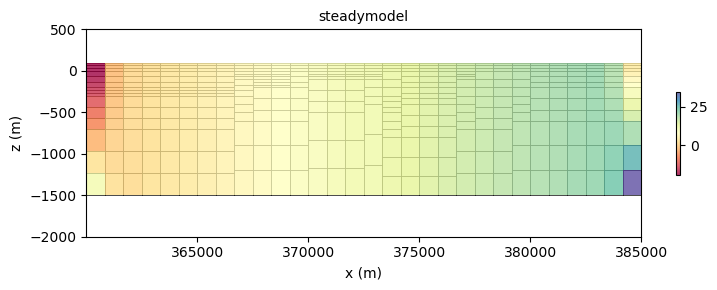

In [212]:
watertable = fm.get_watertable(geomodel, fm.head)
fm.plot_transect(spatial, structuralmodel, 'head', vectors = True)#,  y0 = 6520000, y1 = 6520000, z1 = 300)#, X0, X1, Y0, Y1)


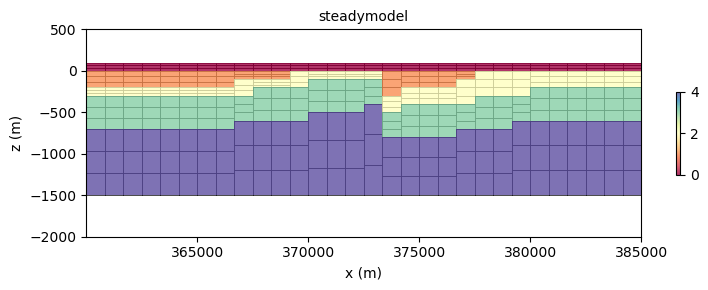

In [206]:
fm.plot_transect(spatial, structuralmodel, 'lith')

In [207]:
obj = fm
methods = [func for func in dir(obj) if callable(getattr(obj, func)) and not func.startswith("__")]
print("Methods in the class:  ",methods)
attributes = [attr for attr in dir(obj) if not callable(getattr(obj, attr)) and not attr.startswith("__")]
print("\nAttributes in the class:  ", attributes)

#for attribute, value in flowmodel.data.__dict__.items(): print(attribute)

Methods in the class:   ['get_watertable', 'plot_plan', 'plot_transect', 'plot_watertable', 'run_flowmodel', 'write_flowmodel']

Attributes in the class:   ['chd', 'chdflow', 'data', 'geomodel', 'gwf', 'head', 'lith', 'logk11', 'logk33', 'mesh', 'newtonoptions', 'obs', 'obsdata', 'observations', 'project', 'rch', 'runtime', 'scenario', 'spd', 'staggered', 'wel', 'xt3d']


### 9. Create and run transient flow model

In [20]:
scenario = 'transientmodel'
well_q = [-2000, -2000]
data.process_wel(geomodel, mesh, spatial, well_q, wel_qlay)
data.strt = fm.head
fm2 = Flowmodel(scenario, project, data, observations, mesh, geomodel)

perlen = 2 * 365 # length of period (days)
nts = 12         # number of time steps for this period
fm2.perioddata = [(perlen, nts, 1.1)] # perlen, nts, tsmult

NameError: name 'wel_qlay' is not defined

In [ ]:
sim = fm2.write_flowmodel(transient = True, chd = True, wel = True, obs = True, rch = True)

   Writing simulation and gwf for  transientmodel  ...
   Time taken to write flow model =  5.524102


In [ ]:
fm2.run_flowmodel(sim, transient = True)

Running simulation for  transientmodel  ...
Model success =  True
   run_time =  10.117995
['DISU', 'NPF', 'IC', 'STO', 'WEL_0', 'CHD_0', 'RCH_0', 'OBS_0', 'OC']
head results shape  (1, 13358)


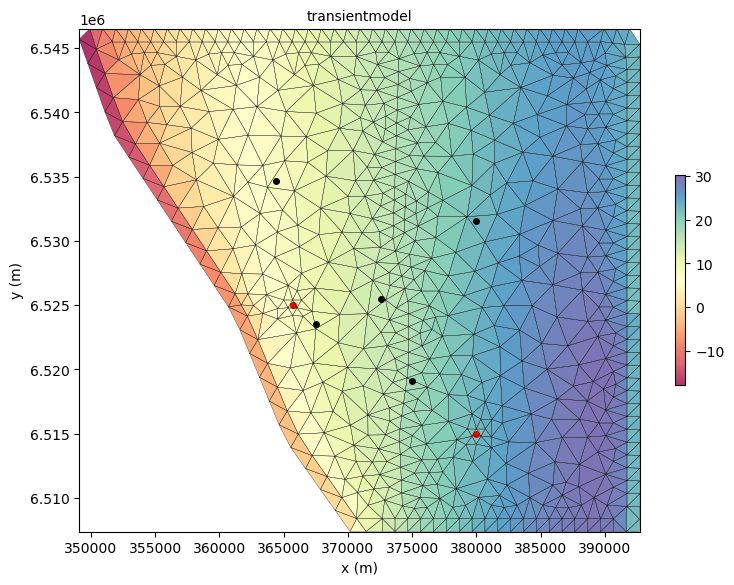

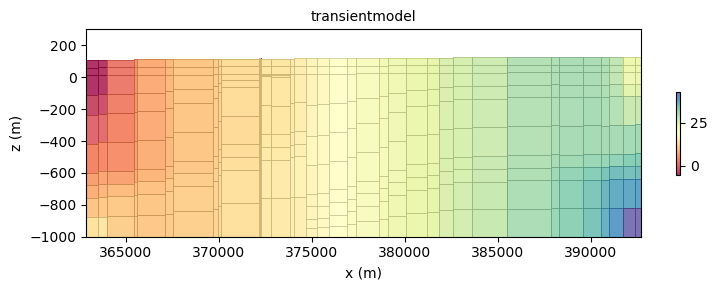

In [ ]:
watertable = fm2.get_watertable(geomodel, fm2.head)
fm2.plot_watertable(spatial, mesh, geomodel, fm2, watertable,)#, extent, vmin, vmax
fm2.plot_transect(spatial, structuralmodel, 'head',  y0 = 6520000, y1 = 6520000, z1 = 300)#, X0, X1, Y0, Y1)